In [1]:
import pandas as pd
import numpy as np
import importlib
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import shap

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

def clean_plot(leg=True, grid=None, font=None):
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    axis_color = 'lightgrey'
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.tick_params(axis='both', color=axis_color)
    
    if leg:
        ax.legend(frameon = False, loc='upper left', bbox_to_anchor=(1, 1))
        
    if grid is not None:
        plt.grid(color='lightgrey', axis = grid, linestyle='-', linewidth=.5)
        
    if font is not None:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
            
            item.set_fontfamily(font['family'])
            item.set_color(font['color'])
            

In [3]:
from src.filter import Filter

In [5]:
gtrain = pd.read_csv("data/garlic_scoring.csv", encoding='latin1')[['PMID', 'abstract', 'paper', 'mesh_terms', 'qual_terms', 'is_useful']]
gtrain['food'] = 'garlic'
ctrain = pd.read_csv("data/cocoa_scoring.csv", encoding='latin1')[['PMID', 'abstract', 'paper', 'mesh_terms', 'qual_terms', 'is_useful']]
ctrain['food'] = 'cocoa'

In [6]:
gtrain = gtrain[gtrain['is_useful'].notnull()]
ctrain = ctrain[ctrain['is_useful'].notnull()]

gtrain['is_useful'] = gtrain['is_useful'].replace(2, 1, regex=True)
ctrain['is_useful'] = ctrain['is_useful'].replace(2, 1, regex=True)

# training_data = pd.concat([gtrain, ctrain], axis=0, ignore_index = True)

In [10]:
gmodel_data = Filter()
cmodel_data = Filter()

gmodel_data.build_features(input_data = gtrain, is_traindata = True)
cmodel_data.build_features(input_data = ctrain, is_traindata = True)

Creating features...


299it [06:03,  1.22s/it]


Creating features...


324it [05:52,  1.09s/it]


In [11]:
def balanced_sample(df, train_frac=.7, val_frac=.2):
    val_s1 = df[df['class'] == 0].sample(frac=val_frac)
    val_s2 = df[df['class'] == 1].sample(frac=val_frac)
    
    val= pd.concat([val_s1, val_s2], axis=0, ignore_index=True, sort=False)
    
    df = df.drop(val_s1.index.tolist() + val_s2.index.tolist(), axis = 0)
    
    y = df.copy()['class']
    x = df.copy().drop('class', axis = 1)
    
    smote_x, smote_y = SMOTE().fit_sample(x, y)

    df = pd.DataFrame(smote_x, columns = x.columns)
    df['class'] = pd.Series(smote_y)
    
    train_s1 = df[df['class'] == 0].sample(frac=train_frac)
    train_s2 = df[df['class'] == 1].sample(frac=train_frac)
    
    test = df.drop(train_s1.index.tolist() + train_s2.index.tolist(), axis = 0)
    
    return pd.concat([train_s1, train_s2], axis=0, ignore_index=True, sort=False), test, val
    
    

gdata = gmodel_data.data.copy()
cdata = cmodel_data.data.copy()

# gdata.to_pickle('misc_save/garlic_train_data.pkl')
# cdata.to_pickle('misc_save/cocoa_train_data.pkl')

# gdata = pd.read_pickle('misc_save/garlic_train_data.pkl')
# cdata = pd.read_pickle('misc_save/cocoa_train_data.pkl')

print(sum(gdata['class'].tolist() + cdata['class'].tolist()) / len(gdata['class'].tolist() + cdata['class'].tolist()))

gtrain, gtest, gval = balanced_sample(gdata)
ctrain, ctest, cval = balanced_sample(cdata)

train = pd.concat([gtrain, ctrain], axis=0, ignore_index=True, sort=False)
test = pd.concat([gtest, ctest], axis=0, ignore_index=True, sort=False)
val = pd.concat([gval, cval], axis=0, ignore_index=True, sort=False) # Does not incorporate SMOTE

0.27287319422150885


In [36]:
y = train.copy()['class']
x = train.copy().drop('class', axis = 1)

# smote_x, smote_y = SMOTE().fit_sample(x, y)

# x = pd.DataFrame(smote_x, columns = x.columns)
# y = pd.Series(smote_y)

# model = RandomForestClassifier(n_estimators = 10)
model = XGBClassifier(n_estimators=80)

model.fit(x, y)

y_test = test.copy()['class']

# Reorder columnt to align variables
x_test = test.copy().drop('class', axis = 1)

predictions = model.predict(x_test)

print('AUC:', roc_auc_score(y_test,predictions), '\n')

print('Confusion Matrix')
print(confusion_matrix(y_test,predictions), '\n')

print('Classification Report')
print(classification_report(y_test,predictions))

AUC: 0.7546296296296298 

Confusion Matrix
[[77 31]
 [22 86]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74       108
         1.0       0.74      0.80      0.76       108

    accuracy                           0.75       216
   macro avg       0.76      0.75      0.75       216
weighted avg       0.76      0.75      0.75       216



In [108]:
y_val = val.copy()['class']

# Reorder columnt to align variables
x_val = val.copy().drop('class', axis = 1)

predictions = model.predict(x_val)

print('AUC:', roc_auc_score(y_val,predictions), '\n')

print('Confusion Matrix')
print(confusion_matrix(y_val,predictions), '\n')

print('Classification Report')
print(classification_report(y_val,predictions))

AUC: 0.6077694235588973 

Confusion Matrix
[[87 27]
 [23 19]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78       114
         1.0       0.41      0.45      0.43        42

    accuracy                           0.68       156
   macro avg       0.60      0.61      0.60       156
weighted avg       0.69      0.68      0.68       156



In [108]:
pd.DataFrame({'feature' : x.columns, 'importance' : model.feature_importances_}).sort_values('importance', ascending=False)

feature  importance
11               qualifier_perc    0.125787
4               chem_term_count    0.100912
1                             E    0.099772
8        mean_mesh_branch_level    0.091082
9                 num_citations    0.080482
0                             D    0.074515
6               food_term_count    0.066924
3   analytical_sub_branch_count    0.063595
14                 spectrometry    0.061125
13            search_term_count    0.056042
10         num_mass_in_abstract    0.043830
7                gen_term_count    0.042776
2                             J    0.036544
12               sci_term_count    0.024656
15            spectrophotometry    0.016630
5                chromatography    0.015328

In [48]:
pd.DataFrame({'feature' : x.columns, 'importance' : model.feature_importances_}).sort_values('importance', ascending=False)

feature  importance
11               qualifier_perc    0.116881
0                             D    0.086174
9                 num_citations    0.081920
1                             E    0.080057
4               chem_term_count    0.078511
6               food_term_count    0.077753
8        mean_mesh_branch_level    0.071925
13            search_term_count    0.068863
2                             J    0.066700
7                gen_term_count    0.058221
10         num_mass_in_abstract    0.055802
3   analytical_sub_branch_count    0.051882
12               sci_term_count    0.036439
5                chromatography    0.025140
14                 spectrometry    0.025069
15            spectrophotometry    0.018664

In [35]:
# load JS visualization code to notebook
shap.initjs()

In [109]:
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[1], shap_values[1], x)

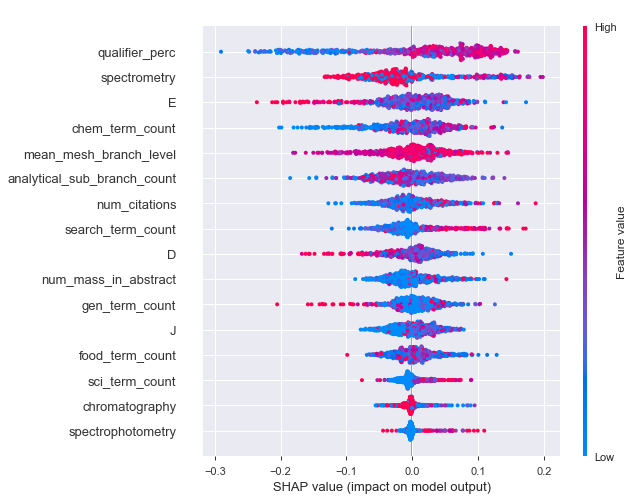

In [111]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], x)

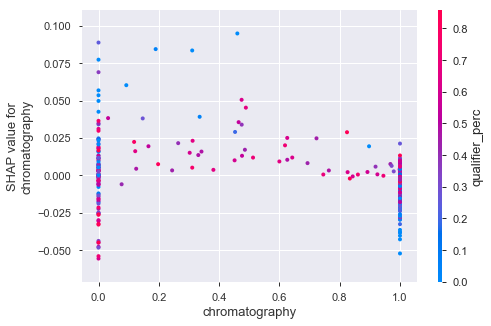

In [112]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("chromatography", shap_values[1], x)

In [65]:
# y = gtrain.copy()['class']
# x = gtrain.copy().drop('class', axis = 1)

# smote_x, smote_y = SMOTE().fit_sample(x, y)

# x = pd.DataFrame(smote_x, columns = x.columns)
# y = pd.Series(smote_y)

# model = RandomForestClassifier(n_estimators = 10)

# model.fit(x, y)

# y_test = gtest.copy()['class']

# # Reorder columnt to align variables
# x_test = gtest.copy().drop('class', axis = 1)

# predictions = model.predict(x_test)

# print('Confusion Matrix')
# print(confusion_matrix(y_test,predictions), '\n')

# print('Classification Report')
# print(classification_report(y_test,predictions))

Confusion Matrix
[[39  8]
 [18 29]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.68      0.83      0.75        47
         1.0       0.78      0.62      0.69        47

   micro avg       0.72      0.72      0.72        94
   macro avg       0.73      0.72      0.72        94
weighted avg       0.73      0.72      0.72        94



In [113]:
import pandas_profiling
pd.concat([gdata,cdata],axis=0,ignore_index=True,sort=False).profile_report()

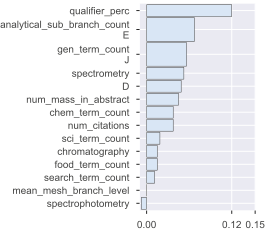

In [116]:
import rfpimp

# rf = RandomForestClassifier(n_estimators=10)

features = ['chem_term_count', 'chromatography', 'food_term_count', ['gen_term_count', 'J'], 'num_citations', 'num_mass_in_abstract', 'qualifier_perc', 'sci_term_count', 'search_term_count', 'spectrometry', 'spectrophotometry', 'D', ['analytical_sub_branch_count', 'E'], 'mean_mesh_branch_level']

I = rfpimp.importances(model, x_test, y_test, features=features)
rfpimp.plot_importances(I)

In [92]:
len(train[(train.chromatography > 0) & (train.spectrometry > 0) & (train['class'] == 1)]) / len(train[(train.chromatography > 0) & (train.spectrometry > 0)])

0.4534412955465587

### Dimensionality Reduction

In [73]:
from sklearn.manifold import TSNE
import umap

tsne = TSNE(n_components=2).fit_transform(pd.concat([gdata,cdata],axis=0,ignore_index=True,sort=False).drop('class', axis=1))
um = umap.UMAP().fit_transform(pd.concat([gdata,cdata],axis=0,ignore_index=True,sort=False).drop('class', axis=1))

C:\Users\forresthooton\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [74]:
tsne = pd.DataFrame(tsne)
um = pd.DataFrame(um)

tsne['class'] = pd.concat([gdata,cdata],axis=0,ignore_index=True,sort=False)['class']
um['class'] = pd.concat([gdata,cdata],axis=0,ignore_index=True,sort=False)['class']

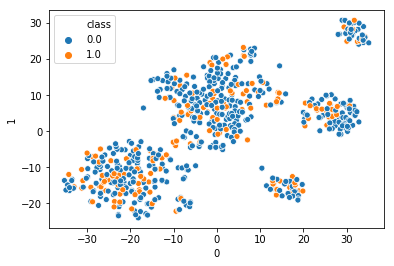

In [75]:
sns.scatterplot(tsne[0], tsne[1], hue=tsne['class'])

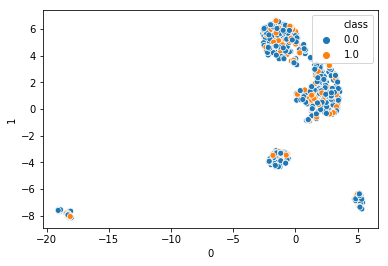

In [76]:
sns.scatterplot(um[0], um[1], hue=um['class'])

In [7]:
milk = pd.read_pickle('misc_save/milk_search_output.pkl')

In [12]:
# mmodel_data = modeldata_util.ModelData('search_selection')
# mmodel_data.build_data(milk, is_traindata = False)

In [121]:
# mmodel_data.data.to_pickle('misc_save/milk_train.pkl')

In [19]:
# milk_data = mmodel_data.data.copy().drop('class', axis=1)
milk_data = pd.read_pickle('misc_save/milk_train.pkl').drop('class', axis=1)
mx = milk_data.copy()

In [37]:
milk_data['pred'] = model.predict(mx)
milk_data['pred_prob'] = [v[1] for v in model.predict_proba(mx)]

In [38]:
milk_data.sort_values('pred_prob', ascending=False).head(15)

chem_term_count  chromatography  food_term_count  gen_term_count  \
PMID                                                                         
17805746              8.0             1.0              2.0             0.0   
29887559              2.0             0.0              3.0             0.0   
28386391              3.0             1.0              3.0             0.0   
20161544              3.0             0.0              4.0             0.0   
29753473              2.0             1.0              2.0             0.0   
30175255              9.0             0.0              5.0             0.0   
29230345              4.0             1.0              2.0             0.0   
30001571              2.0             1.0              2.0             0.0   
15048528              2.0             0.0              2.0             0.0   
29389253              1.0             0.0              3.0             0.0   
29765403              3.0             1.0              1.0             0.0   
17805897              6.0             1.0              1.0             0.0   
27275838              1.0             1.0              7.0             1.0   
27916960              1.0             1.0             11.0             1.0   
11002129              1.0             1.0              1.0             0.0   

          num_citations  num_mass_in_abstract  qualifier_perc  sci_term_count  \
PMID                                                                            
17805746            0.0                   0.0             0.0             0.0   
29887559            0.0                   0.0             0.0             0.0   
28386391            0.0                   0.0             0.0             0.0   
20161544            0.0                   0.0             0.0             0.0   
29753473            0.0                   0.0             0.0             0.0   
30175255            0.0                   0.0             0.0             0.0   
29230345            0.0                   0.0             0.0             0.0   
30001571            0.0                   0.0             0.0             0.0   
15048528            0.0                   0.0             0.0             0.0   
29389253            0.0                   1.0             0.0             0.0   
29765403            0.0                   0.0             0.0             0.0   
17805897            0.0                   0.0             0.0             0.0   
27275838            0.0                   1.0             0.0             0.0   
27916960            0.0                   1.0             0.0             0.0   
11002129            0.0                   1.0             0.0             0.0   

          search_term_count  spectrometry  spectrophotometry    D    E    J  \
PMID                                                                          
17805746                0.0           0.0                0.0  0.0  0.0  0.0   
29887559                0.0           1.0                0.0  0.0  0.0  0.0   
28386391                0.0           0.0                0.0  0.0  0.0  0.0   
20161544                0.0           1.0                0.0  0.0  0.0  0.0   
29753473                0.0           0.0                0.0  0.0  0.0  0.0   
30175255                0.0           1.0                0.0  0.0  0.0  0.0   
29230345                0.0           1.0                0.0  0.0  0.0  0.0   
30001571                0.0           1.0                0.0  0.0  0.0  0.0   
15048528                0.0           1.0                0.0  0.0  0.0  0.0   
29389253                0.0           1.0                0.0  0.0  0.0  0.0   
29765403                0.0           0.0                0.0  0.0  0.0  0.0   
17805897                0.0           0.0                0.0  0.0  0.0  0.0   
27275838                6.0           1.0                0.0  0.0  0.0  0.0   
27916960               10.0           1.0                0.0  0.0  0.0  0.0   
11002129                0.0           0.0

No handles with labels found to put in legend.


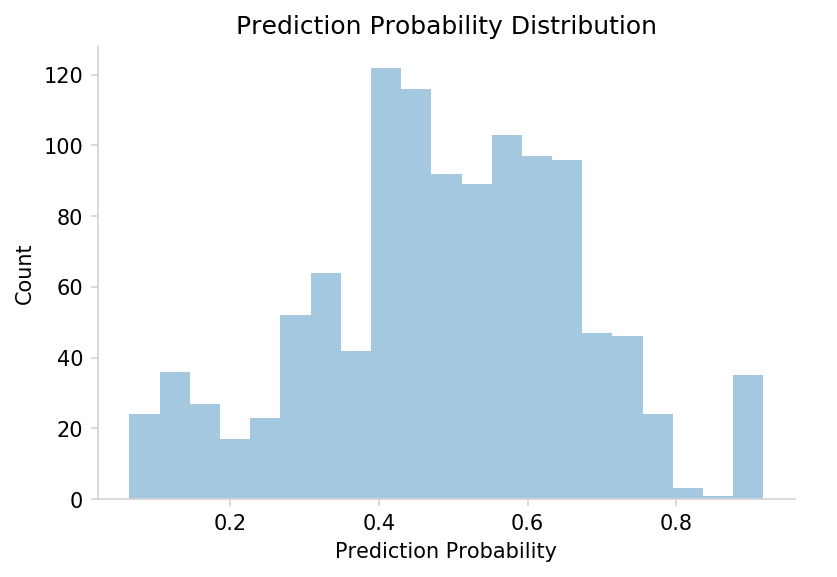

In [39]:
ax = sns.distplot(milk_data['pred_prob'], kde=False)

ax.set_title('Prediction Probability Distribution')
ax.set_xlabel('Prediction Probability')
ax.set_ylabel('Count')

clean_plot()

In [40]:
sum(milk_data['pred']) / len(milk_data)

0.49567474048442905

In [43]:
sum(milk_data['pred']), len(milk_data)

(573.0, 1156)

In [46]:
len(milk_data[milk_data['pred_prob'] > .85])

36